# Monte Carlo Simulation 

Today, we will work with the Lennard Jones equation. 

$$ U(r) = 4 \epsilon \left[\left(\frac{\sigma}{r}\right)^{12} -\left(\frac{\sigma}{r}\right)^{6} \right] $$

Reduced Units:

$$ U^*\left(r_{ij} \right) = 4 \left[\left(\frac{1}{r^*_{ij}}\right)^{12} -\left(\frac{1}{r^*_{ij}}\right)^{6} \right] $$


In [1]:
import math
import os
import random

import matplotlib.pyplot as plt

%matplotlib notebook

def calculate_LJ(r_ij): 
    """
    The LJ interaction energy between two particles.
    
    Computes the pairwise Lennard jones interaction energy based on the separation distance in reduced units.
    
    Parameters
    ----------
    r_ij : float
        The distance between the particles in reduced units.
        
    Returns
    -------
    pairwise_energy : float
        The pairwise Lennard Jones interaction energy in reduced units.
    
    """
    r6_term = math.pow(1/r_ij, 6)
    r12_term = math.pow(r6_term, 2)
    
    pairwise_energy = 4 * (r12_term - r6_term)
    
    return pairwise_energy

def calculate_distance(coord1, coord2, box_length=None):
    """
    Calculate the distance between two 3D coordinates.
    
    Parameters
    ----------
    coord1, coord2 : list
        The atomic coordinates [x, y, z]
        
    box_length : float, optional
        The box length. This function assumes box is a cube.
        
    Returns
    -------
    distance: float
        The distance between the two atoms
    
    """
    #Do periodic boundary corrections if given a box_length
    if box_length is not None:
        #Distance = sqrt(sum of square differences of each dimension)
        #initialize the sum of square differences to 0
        sum_square_diff = 0
        
        #Iterate through dimensions
        for i in range(len(coord1)):
            
            #Find the raw distance between the two coordinates in this dimension
            dim_dist_uncorrected = math.fabs(coord1[i] - coord2[i])
            
            #Periodic boundary corrections
            #If raw distance is less than half the box_length, no corrections are needed
            if dim_dist_uncorrected <= box_length / 2:
                dim_dist_corrected = dim_dist_uncorrected
            
            #If raw distance is greater than half the box length and less than one whole box length, correct accordingly
            elif (dim_dist_uncorrected > box_length / 2 and dim_dist_uncorrected <= box_length):
                dim_dist_corrected = box_length - dim_dist_uncorrected
            
            #If raw distance is greater than one whole box length, correct accordingly
            else:
                dim_dist_corrected = dim_dist_uncorrected - box_length * round(dim_dist_uncorrected / box_length)
            
            #Add the square difference to the total sum
            sum_square_diff += (dim_dist_corrected)**2
        
        #Calculate distance after finding the sum of square differences
        distance = math.sqrt(sum_square_diff)
        
    #Otherwise assume no periodic boundaries    
    else:
        sum_square_diff = 0
    
        for i in range(len(coord1)):
            sum_square_diff += (coord1[i] - coord2[i])**2

        distance = math.sqrt(sum_square_diff)

    return distance

def calculate_total_energy(coordinates, box_length, cutoff):
    """
    Calculate the total Lennard Jonest energy of a system of particles.
    
    Parameters
    ----------
    coordinates : list
        Nested list containing particle coordinates.
        
    Returns
    -------
    total_energy : float
        The total pairwise Lennard jonest energy of the system of particles.
    """
    
    total_energy = 0
    
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            dist_ij = calculate_distance(coordinates[i], coordinates[j], box_length=box_length)
            
            if dist_ij < cutoff:
                interaction_energy = calculate_LJ(dist_ij)
                total_energy += interaction_energy
            
    return total_energy
            
def calculate_tail_correction(num_particles, box_length, cutoff):
    """
    Calculate the long range tail correction
    """
    
    const1 = (8 * math.pi * num_particles ** 2) / (3 * box_length ** 3)
    const2 = (1/3) * (1 / cutoff)**9 - (1 / cutoff) **3
    
    return const1 * const2

def calculate_pair_energy(coordinates, i_particle, box_length, cutoff):
    """
    Calculate the interaction energy of a particle with it senvironment (all other particles in the system)
    
    Parameters
    ----------
    coordinates: list
        The coordinates for all the particles in the system.
    
    i_particle: int
        The particle index for which to calculate the energy.
        
    box_length : float
        The length of the simulation box.
        
    cutoff : float
        The simulation cutoff. Beyond this distance, interactions are not calculated
        
    Returns
    -------
    e_total : float
        The pairwise interaction energy of the i-th particle with all other particles in the system.
    
    """
    
    e_total = 0
    
    num_atoms = len(coordinates)
    
    for j in range(num_atoms):
        if j != i_particle:
            dist_ij = calculate_distance(coordinates[i_particle], coordinates[j], box_length=box_length)

            if dist_ij < cutoff:
                interaction_energy = calculate_LJ(dist_ij)
                e_total += interaction_energy
    
    return e_total

def accept_or_reject(delta_e, beta):
    """
    Accept or reject based on change in energy and temperature.
    
    """
    
    if delta_e <= 0:
        accept = True
    else:
        random_number = random.random()
        p_acc = math.exp(-beta*delta_e)
        
        if random_number < p_acc:
            accept = True
        else:
            accept = False
            
    return accept

def generate_config(num_particles, box_length):
    """
    Generates initial system configuration given a number of particles and a box length
    
    Parameters
    ----------
    num_particles : int
        The desired number of particles in the system.
        
    box_length : int
        The length of the box. 
        
    Returns
    -------
    coordinates : list
        A two dimensional list containing atomic coordinates in the form [x, y, z].
            
    box_length : int
        The length of the box.
    """
    #Initialize coordinates list
    coordinates = [] 
    
    for i in range(num_particles):
        x_rand = random.uniform(0, box_length)
        y_rand = random.uniform(0, box_length)
        z_rand = random.uniform(0, box_length)
        
        coordinate = [x_rand, y_rand, z_rand]
        
        #Check if coordinate already exists. If so, generate a random coordinate until a new one is found
        while coordinate in coordinates:
            x_rand = random.uniform(0, box_length)
            y_rand = random.uniform(0, box_length)
            z_rand = random.uniform(0, box_length)

            coordinate = [x_rand, y_rand, z_rand]
        
        #Add the new coordinate to the list
        coordinates.append(coordinate)
        
    return coordinates, box_length

def read_xyz(filepath):
    """
    Reads coordinates from an xyz file.
    
    Parameters
    ----------
    filepath : str
       The path to the xyz file to be processed.
       
    Returns
    -------
    atomic_coordinates : list
        A two dimensional list containing atomic coordinates
    """
    
    with open(filepath) as f:
        box_length = float(f.readline().split()[0])
        num_atoms = float(f.readline())
        coordinates = f.readlines()
    
    atomic_coordinates = []
    
    for atom in coordinates:
        split_atoms = atom.split()
        
        float_coords = []
        
        # We split this way to get rid of the atom label.
        for coord in split_atoms[1:]:
            float_coords.append(float(coord))
            
        atomic_coordinates.append(float_coords)
        
    
    return atomic_coordinates, box_length

In [2]:
calculate_LJ(1)

0.0

In [3]:
calculate_LJ(math.pow(2,(1/6)))

-1.0

In [4]:
assert 1 == 1

In [5]:
#If we assert something that is not True (otherwise known as False), we will get an assert error
# assert 1 == 0

In [6]:
assert calculate_LJ(1) == 0
assert calculate_LJ(math.pow(2, (1/6))) == -1

In [7]:
point_1 = [0, 0, 0]
point_2 = [1, 0, 0]

dist1 = calculate_distance(point_1, point_2)

assert dist1 == 1

In [8]:
point_3 = [0, 0, 0]
point_4 = [0, 1, 1]

dist2 = calculate_distance(point_3, point_4)
assert math.sqrt(2) == dist2

In [9]:
atomic_coordinates = [[0, 0, 0], [0, math.pow(2, 1/6), 0], [0, 2*math.pow(2, 1/6), 0]]

In [11]:
file_path = os.path.join('lj_sample_configurations', 'lj_sample_config_periodic1.txt')

coordinates, box_length = read_xyz(file_path)

In [12]:
box_length

10.0

In [13]:
len(coordinates)

800

In [14]:
calculate_total_energy(coordinates, 10, 3)

-4351.540194543858

## Flow of Calculations

1. Generate an initial system state `m`.
2. Choose an atom with uniform probability from state `m`.
3. Propose a new state `n` by translating the particle with a uniform displacement in each direction.
4. Calculate the energy change for the particle.
5. Accept or reject new state

In [15]:
delta_energy = -1
beta = 1
assert accept_or_reject(delta_energy, beta) is True

In [16]:
delta_energy = 0
beta = 1
assert accept_or_reject(delta_energy, beta) is True

In [17]:
random.seed(0)
random.random()

0.8444218515250481

In [18]:
delta_energy = 1
beta = 1
p_acc = math.exp(-1)
print(p_acc)

0.36787944117144233


In [19]:
random.seed(0)
delta_e = 1
beta = 1
assert accept_or_reject(delta_e, beta) is False

In [20]:
#Unset random seed
random.seed()

In [21]:
coordinates = [[0, 0, 0] , [0, 0, 2**(1/6)], [0, 0, 2*(2**(1/6))]]

assert calculate_pair_energy(coordinates, 1, 10, 3) == -2

assert calculate_pair_energy(coordinates, 0, 10, 3) == calculate_pair_energy(coordinates, 2, 10, 3)

# Simulation Loop

In [23]:
import os

#Set simulation parameters
reduced_temperature = 0.9
num_steps = 5000
max_displacement = 0.1
cutoff = 3

# Reporting information
freq = 1000
steps = []
energies = []
all_coordinates = []

#Calculated quantities
beta = 1/reduced_temperature

#Read initial coordinates
file_path = os.path.join('lj_sample_configurations', 'lj_sample_config_periodic1.txt')
coordinates, box_length = read_xyz(file_path)
num_particles = len(coordinates)

#Calculated based on simulation inputs
total_energy = calculate_total_energy(coordinates, box_length, cutoff)
total_energy += calculate_tail_correction(num_particles, box_length, cutoff)

for step in range(num_steps):
        
        # 1. Randomly pick one of num_particles particles
        random_particle = random.randrange(num_particles)
        
        # 2. Calculate the interaction energy of the selected particle with the system. Store this value.
        current_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
        
        # 3. Generate a random x, y, z displacement range (-max_displacement, max_displacement)
        x_rand = random.uniform(-max_displacement, max_displacement)
        y_rand = random.uniform(-max_displacement, max_displacement)
        z_rand = random.uniform(-max_displacement, max_displacement)
        
        # 4. Modify the coordinate of selected particle by generated displacements.
        coordinates[random_particle][0] += x_rand
        coordinates[random_particle][1] += y_rand
        coordinates[random_particle][2] += z_rand
        
        # 5. Calculate the new interaction energy of moved particle, store this value.
        proposed_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
        
        # 6. Calculate energy change and decide if we accept the move.
        delta_energy = proposed_energy - current_energy
        
        accept = accept_or_reject(delta_energy, beta)
        
        # 7. If accept, keep movement, If not revert to old position
        if accept:
            total_energy += delta_energy
        else:
            #Move is not accepted, roll back coordinates
            coordinates[random_particle][0] -= x_rand
            coordinates[random_particle][1] -= y_rand
            coordinates[random_particle][2] -= z_rand
        
        # 8. Print the energy at certain intervals.
        if step % freq == 0:
            print(step, total_energy/num_particles)
            steps.append(step)
            energies.append(total_energy/num_particles)
            all_coordinates.append(coordinates)

0 -5.687536347860019
1000 -5.646492461613382
2000 -5.67035525667461
3000 -5.636662030020916
4000 -5.645778597329415


<IPython.core.display.Javascript object>


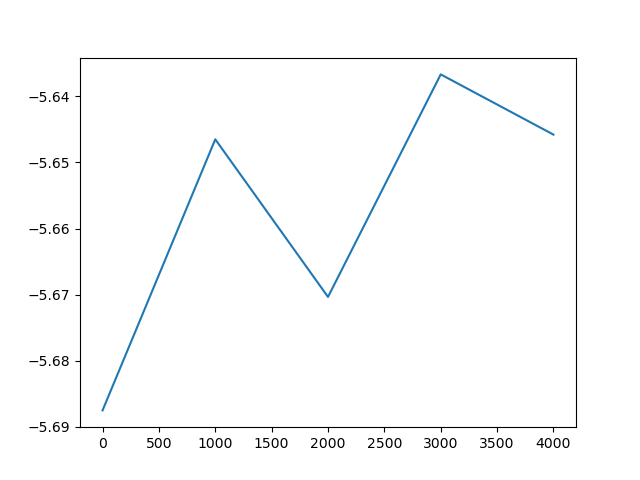

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(steps, energies)